# МОиВС "Генеративные модели", 5-й модуль

# Homework 1

В этой домашней работе вам предстоит добавить к BERT'у декодерную часть и решить задачу генерации суммаризаций для текстов новостей на русском языке.

Дополнительно к этому на отличную оценку потребуется реализовать подсчет метрик качества и менее жадную стратегию выбора следующего токена для генерации.

*Мы сразу вас предостерегаем попасть в петлю бесконечного дообучения модели. Эта домашка не на пробитие скора. Мы будем проверять, что вы, в целом, сделали все верно и смогли получить какую-то более-менее адекватную (такую, которая заметно лучше той, что была до начала обучения) генерацию. Таким образом, если вы видите, что модель учится, не надо дообучать её сутками. Нескольких часов точно должно хватить.*



---


---
По любым вопросам касательно этой домашней работы обращайтесь ко своим ассистентам




In [1]:
%%bash
pip install transformers datasets evaluate bert_score rouge_score

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, AutoTokenizer

## Подготовка данных (0.5 балла)

Мы воспользуемся датасетом с 🤗 Ильи Гусева "gazeta". Он представляет собой пары (полный текст новости -- его саммари). Пары были взяты с одноименного сайта в домене .ru

Более подробно про датасет можно прочитать [здесь](https://huggingface.co/datasets/IlyaGusev/gazeta)



In [3]:
# Загрузим данные с попощью библиотеки библиотеки datasets

from datasets import load_dataset
dataset = load_dataset('IlyaGusev/gazeta', revision="v2.0", split='train[:10%]')


In [4]:
dataset

Dataset({
    features: ['text', 'summary', 'title', 'date', 'url'],
    num_rows: 6096
})

Вы должны помнить, что тексты перед подачей в модель необходимо **токенизировать**.

Добавьте паддинг до `max_length=512` для обучающих данных, а также до `max_length=128` для меток.

Используйте обрезку текстов, длина которых в токенах превышает `max_length`

In [5]:
# Подготовим данные для модели Bert

model_name = 'deepvk/bert-base-uncased' # Указание модели BERT

tokenizer = AutoTokenizer.from_pretrained(model_name)
# special_tokens = {'eos_token': '[EOS]'}
# tokenizer.add_special_tokens(special_tokens)

def preprocess(examples, use_padding=True):
    model_inputs = tokenizer(examples['text'], padding= 'max_length' if use_padding else '', truncation=True, max_length=512)
    summary = tokenizer(examples['summary'], padding= 'max_length' if use_padding else '', truncation=True, max_length=128)
    model_inputs['labels'] = summary['input_ids']
    return model_inputs

In [6]:
tokenized_dataset = dataset.map(preprocess, batched=False)
tokenized_dataset.set_format('torch')

Размер батча советуем подбирать таким образом, чтоб утилизировать максимум доступной VRAM

In [7]:
tokenized_dataset

Dataset({
    features: ['text', 'summary', 'title', 'date', 'url', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 6096
})

In [8]:
from torch.utils.data import DataLoader
splitted_dataset = tokenized_dataset.train_test_split(test_size=0.1)
train_dataloader = DataLoader(splitted_dataset['train'], batch_size=12, shuffle=True)
eval_dataloader = DataLoader(splitted_dataset['test'], batch_size=8, shuffle=False)

## Реализация Decoder-cети (3 балла)

В данном разделе вам необходимо **реализовать собственный декодер для генерации текста**.

Можете вдохновляться кодом с семинара 1 по GPT. В инициализации весов стоит (но необязательно) проявить смекалку

In [12]:
bert = BertModel.from_pretrained('deepvk/bert-base-uncased')

In [13]:
torch.full([a.size()[0], 1], tokenizer.sep_token_id)

tensor([[2]])

In [14]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PositionalEncoding(nn.Module):
    def __init__(self, hidden_size, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, hidden_size, device=device)
        position = torch.arange(0, max_len, dtype=torch.float, device=device).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_size, 2, device=device).float() * (-math.log(10000.0) / hidden_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class BertSummarizerBase(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', hidden_size=768, num_decoder_layers=3, num_heads=8, dropout=0.1):
        super(BertSummarizerBase, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name).to(device)
        self.hidden_size = hidden_size
        self.tokenizer = tokenizer
        self.embedding = nn.Embedding(self.bert.config.vocab_size, hidden_size).to(device)
        self.positional_encoding = PositionalEncoding(hidden_size)
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=hidden_size, nhead=num_heads, dropout=dropout, batch_first=True).to(device),
            num_layers=num_decoder_layers,
        ).to(device)
        self.fc_out = nn.Linear(hidden_size, self.bert.config.vocab_size).to(device) 

    def generate_square_subsequent_mask(self, T):
        return torch.triu(
            torch.full((T, T), float('-inf'), device=device, dtype=torch.float64),
            diagonal=1,
        )

    def forward(self, input_ids, attention_mask, decoder_input_ids):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        decoder_input_ids = decoder_input_ids.to(device)

        encoder_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        memory = encoder_outputs.last_hidden_state

        embedded = self.embedding(decoder_input_ids)
        embedded = self.positional_encoding(embedded)

        decoder_attention_mask = self.generate_square_subsequent_mask(embedded.size(1)).to(device)
        output = self.decoder(tgt=embedded, memory=memory, tgt_mask=decoder_attention_mask)

        output = self.fc_out(output)
        return output

    def generate(self, input_ids, attention_mask, tokenizer, max_length=50):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        batch_size = input_ids.shape[0]
        generated = [[] for _ in range(batch_size)]
        
        decoder_input_ids = torch.full((batch_size, 1), tokenizer.cls_token_id, dtype=torch.long, device=input_ids.device)
        with torch.no_grad():
            encoder_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            memory = encoder_outputs.last_hidden_state

        for _ in range(max_length):
            with torch.no_grad():
                embedded = self.embedding(decoder_input_ids)
                embedded = self.positional_encoding(embedded)
                decoder_attention_mask = self.generate_square_subsequent_mask(embedded.size(1)).to(device)
                output = self.decoder(tgt=embedded, memory=memory, tgt_mask=decoder_attention_mask)
                output = self.fc_out(output)
            next_token_logits = output[:, -1, :]
            next_tokens = self.get_next_token(next_token_logits)
            
            for i, token in enumerate(next_tokens.squeeze(1)):
                generated[i].append(token.item())
            
            decoder_input_ids = torch.cat([decoder_input_ids, next_tokens], dim=-1)
            
            if all(tokenizer.eos_token_id in seq for seq in generated):
                break
        
        return [tokenizer.decode(ids, skip_special_tokens=True) for ids in decoder_input_ids]

    def get_next_token(self, logits):
        raise NotImplementedError("This method should be implemented in derived classes.")

class BertSummarizer(BertSummarizerBase):
    def get_next_token(self, logits):
        return torch.argmax(logits, dim=-1).unsqueeze(1)



In [15]:
eval_data_sample = next(iter(eval_dataloader))
model = BertSummarizer(
    bert_model_name=model_name,
)
model.generate(eval_data_sample['input_ids'], eval_data_sample['attention_mask'], tokenizer)

['гуля ##⚠ sp вну менедж сыновья рау земельные англииского воспользовавшись цин чрезмер управления стару рыжая удовлетворение ##щихся существу андрее задумы ##денное вну ##щихся существу андрее начинаите риэл ##щихся ##фикация сыновья наидут взду ##щихся ##фикация появление могло скидка соуса репли ##ич классическои вза обрести отделе ##щихся англичан укрепляет создается web феми',
 '##________________ web довери применять шлем класс ##wi web довери применять реичел ##ские ##щихся англичан укрепляет дpу сыновья технологи скину приготовление беспровод смеси нари довери применять официальное северу ##нσ ##щихся web довери довери web довери свадь 1966 ##ваетесь кефира ##ні стремительно привлечения нари довери брук прическу web размно администратора ориф дна',
 'темная пpeд ##фикация появление определенным ##фикация появление определенным вcе ##денное класс переводы занимали вечернее отсюда платьев последовали баба ##237 ##жете незнаком недолго ##стное ##искими цирк появление определенным 

## Обучение модели (1 балл)

<small> 0.25 балла за простейший рабочий цикл; </small>

<small> +0.5 балла за графики для лосса и метрик на трейне и валидации.</small>

В данном разделе вам необходимо **реализовать цикл для обучения модели**


In [16]:
len(train_dataloader), len(eval_dataloader)

(458, 77)

In [17]:
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.autograd.set_detect_anomaly(True)

model = BertSummarizer(bert_model_name=model_name).to(device)

for param in model.bert.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4) 


In [18]:
# шаги для обучения и валидации
def shift_decoder_input(input_ids):
    pad_column = torch.full([input_ids.size()[0], 1], tokenizer.pad_token_id, device=device)
    return torch.cat([input_ids[:, 1:], pad_column], dim=1)

def train_step(model, input_ids, attention_mask, decoder_input_ids, optimizer, criterion, device):
    model.train()
    
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    decoder_input_ids = decoder_input_ids.to(device)
    labels = decoder_input_ids[:,1:].to(device)
    decoder_input_ids = decoder_input_ids[:,:-1]
    
    optimizer.zero_grad()
    outputs = model(input_ids, attention_mask, decoder_input_ids)
    
    logits = outputs.reshape(-1, outputs.size(-1))
    labels = labels.reshape(-1)
    loss = criterion(logits, labels)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    return loss.item()

def validate_step(model, input_ids, attention_mask, decoder_input_ids, criterion, device):
    model.eval()
    
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = decoder_input_ids[:,1:].to(device)
    decoder_input_ids = decoder_input_ids[:,:-1]
    with torch.no_grad():
        outputs = model(input_ids, attention_mask, decoder_input_ids)
        logits = outputs.reshape(-1, outputs.size(-1))
        labels = labels.reshape(-1)
        loss = criterion(logits, labels)

    return loss.item(), outputs


In [19]:
# model = model.to('cuda')
eval_data_sample = next(iter(eval_dataloader))
model.generate(eval_data_sample['input_ids'][:1], eval_data_sample['attention_mask'][:1], tokenizer)

['предприятие очередную ##надо ##рубить ##рают предприятие зная урока конфиденци але ##равли жив постоянного вар пома пету ##стречу вади представителями реи фак яку ##стречу экономить 🅱 вади представителями ##стречу вади остановился рут гражданин подпи запомни рекор соблюдение ##nye деток художественнои ##рядно диаметром активного 02 ” агентства ##емого народная мира запомни праздни']

## Метрики качества (1 балл)

<small>По 0.33 балла за реализацию каждой из предлагаемых метрик</small>

**Реализуйте функицию для подсчета метрик качества суммаризации.**

Докуметация по некотрым метрикам:
 1. [HuggingFace Rouge](https://huggingface.co/spaces/evaluate-metric/rouge)
 2. [HuggingFace Bleu](https://huggingface.co/spaces/evaluate-metric/bleu)
 3. [HuggingFace BERT Score](https://huggingface.co/spaces/evaluate-metric/bertscore)

In [20]:
from evaluate import load
bertscore = load("bertscore")
bleu = load("bleu")
rouge = load('rouge')

def compute_metrics(predictions, references):
    bleu_score = bleu.compute(predictions=predictions, references=references)
    rouge_score = rouge.compute(predictions=predictions, references=references)
    bertscore_score = bertscore.compute(predictions=predictions, references=references, lang='ru')
    return bleu_score, rouge_score, bertscore_score

def evaluation(model, tokenizer, dataloader):
    references = []
    predictions = []
    for batch in tqdm(dataloader, desc="Generating summaries"):
        batch_predictions = model.generate(batch['input_ids'], batch['attention_mask'], tokenizer)
        predictions.extend(batch_predictions)
        references.extend(batch['summary'])
    
    bleu_score, rouge_score, bertscore_score = compute_metrics(predictions, references)
    return bleu_score, rouge_score, bertscore_score


In [21]:
# calculate metrics
bleu_score, rouge_score, bertscore_score = evaluation(model, tokenizer, eval_dataloader)
print(bleu_score, rouge_score, bertscore_score)

Generating summaries: 100%|██████████| 77/77 [00:27<00:00,  2.79it/s]


{'bleu': 0.0, 'precisions': [0.0015068293394254605, 0.0, 0.0, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 1.556143867478537, 'translation_length': 41146, 'reference_length': 26441} {'rouge1': 0.002896174863387978, 'rouge2': 0.0, 'rougeL': 0.0029195940671350507, 'rougeLsum': 0.002798594847775176} {'precision': [0.47774726152420044, 0.502352237701416, 0.46892476081848145, 0.5304083824157715, 0.5034491419792175, 0.4700661301612854, 0.5202888250350952, 0.5233337879180908, 0.5213810205459595, 0.5145599246025085, 0.5280308723449707, 0.46392983198165894, 0.4990634620189667, 0.5222765803337097, 0.4616907835006714, 0.48131710290908813, 0.509079098701477, 0.5091527700424194, 0.5243910551071167, 0.5182185173034668, 0.506880521774292, 0.5050449967384338, 0.5090385675430298, 0.5006551742553711, 0.48978686332702637, 0.5051277875900269, 0.5180834531784058, 0.5146801471710205, 0.5122337341308594, 0.5327963829040527, 0.5339908599853516, 0.5102331638336182, 0.5503582954406738, 0.485686331987381, 0.480

## Обучение модели (0.5 балла)
**Обучите модель, сохраните лучшую версию** (метод `.save_pretrained()` объекта класса AutoModel... или `torch.save()`) **и добавьте пример генерации**. Учтите, что если изменялся токенизатор (а лучше просто по умолчанию), его тоже нужно сохранить. Если планируете продолжить обучение

Для сравнения оценки качества генерации по значениям реализованных метрик можете запустить ruT5-small без дообучения. Мы намеренно даем бейзлайн именно в таком виде.

In [22]:
import numpy as np
plt.ion()
bleu_scores, rouge_scores, bertscore_scores = [], [], []
train_losses = []
val_losses = []
num_epochs = 20


In [24]:
# Загрзка модели

loaded_data = torch.load('metrics_data.pt')
bleu_scores = loaded_data['bleu_scores'].tolist()
rouge_scores = loaded_data['rouge_scores'].tolist()
bertscore_scores = loaded_data['bertscore_scores'].tolist()
train_losses = loaded_data['train_losses'].tolist()
val_losses = loaded_data['val_losses'].tolist()

model_save_path = 'my_summarizer_model_10%_5_ep.pt'
model = BertSummarizer(bert_model_name=model_name)
model.load_state_dict(torch.load(model_save_path))


start_epoch = 5

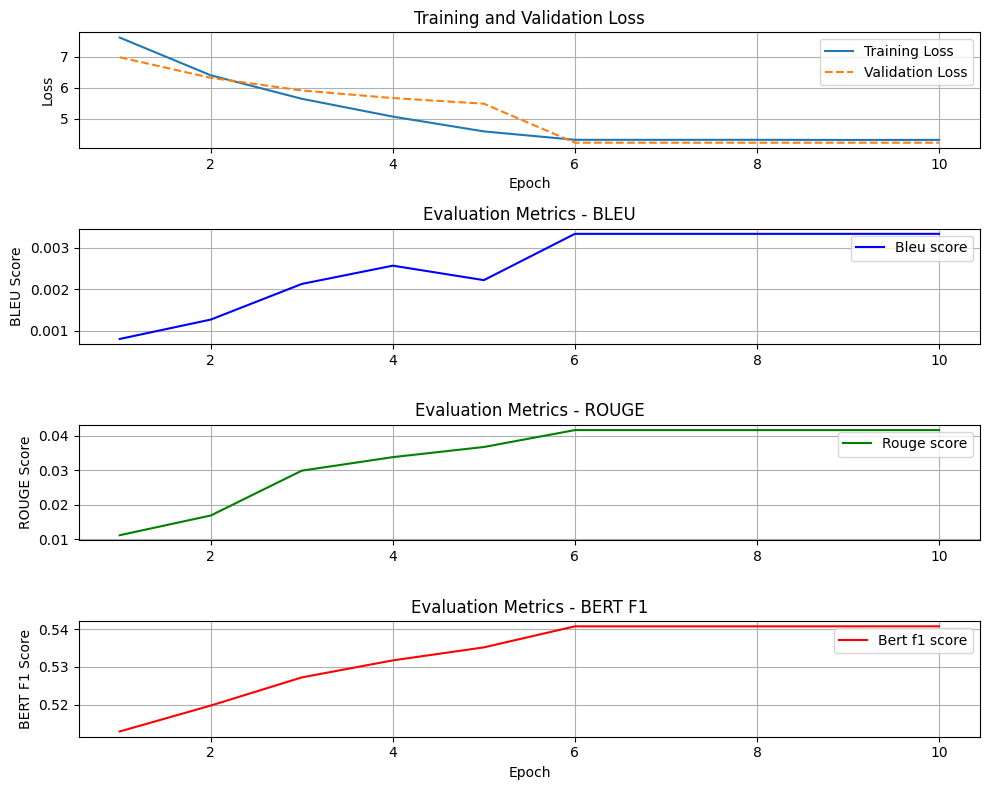

Training Progress:  33%|███▎      | 5/15 [20:41<41:14, 247.43s/it]

Epoch [10/20], Train Loss: 4.3179, Validation Loss: 4.2268
BLEU: 0.0033, ROUGE-L: 0.0416, BERTScore: 0.5407


Training Progress:  33%|███▎      | 5/15 [20:48<41:36, 249.67s/it]


KeyboardInterrupt: 

In [25]:

for epoch in tqdm(range(start_epoch, num_epochs), desc="Training Progress"):
    running_train_loss = 0.0
    running_val_loss = 0.0
    
    batch_iterator = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for batch_idx, sample in enumerate(batch_iterator):
        loss_item = train_step(
            model,
            sample['input_ids'], 
            sample['attention_mask'], 
            sample['labels'],
            optimizer, 
            criterion,
            device
        )
        running_train_loss += loss_item
    train_losses.append(running_train_loss / len(train_dataloader))

    model.eval()
    total_val_loss = 0.0
    decoded_outputs = []
    real_outputs = []
    for val_batch_idx, val_sample in enumerate(eval_dataloader):
        val_loss_item, outputs = validate_step(
            model,
            val_sample['input_ids'],
            val_sample['attention_mask'],
            val_sample['labels'],
            criterion,
            device
        )
        max_outputs = torch.argmax(outputs, dim=-1)
        decoded_outputs.extend(tokenizer.batch_decode(max_outputs, skip_special_tokens=True))
        real_outputs.extend(val_sample['summary'])
        total_val_loss += val_loss_item
    val_loss = total_val_loss / len(eval_dataloader)
    val_losses.append(val_loss)
    bleu_score, rouge_score, bertscore_score = compute_metrics(decoded_outputs, real_outputs)
    bleu_scores.append(bleu_score['bleu'])
    rouge_scores.append(rouge_score['rougeL'])
    bertscore_scores.append(np.mean(bertscore_score['f1']))

    clear_output(wait=True)
    plt.figure(figsize=(16, 8))

    plt.subplot(4, 1, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(range(1, len(bleu_scores) + 1), bleu_scores, label='Bleu score', color='blue')
    plt.ylabel('BLEU Score')
    plt.title('Evaluation Metrics - BLEU')
    plt.grid(True)
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(range(1, len(rouge_scores) + 1), rouge_scores, label='Rouge score', color='green')
    plt.ylabel('ROUGE Score')
    plt.title('Evaluation Metrics - ROUGE')
    plt.grid(True)
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(range(1, len(bertscore_scores) + 1), bertscore_scores, label='Bert f1 score', color='red')
    plt.ylabel('BERT F1 Score')
    plt.xlabel('Epoch')
    plt.title('Evaluation Metrics - BERT F1')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


    epoch_train_loss = running_train_loss / len(train_dataloader)
    epoch_val_loss = val_loss

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")
    print(f"BLEU: {bleu_score['bleu']:.4f}, ROUGE-L: {rouge_score['rougeL']:.4f}, BERTScore: {np.mean(bertscore_score['f1']):.4f}")


plt.ioff()


In [26]:
data = {
    'bleu_scores': torch.tensor(bleu_scores),
    'rouge_scores': torch.tensor(rouge_scores),
    'bertscore_scores': torch.tensor(bertscore_scores),
    'train_losses': torch.tensor(train_losses),
    'val_losses': torch.tensor(val_losses)
}

# сохранение метрик в файл
torch.save(data, 'metrics_data.pt')

In [27]:
model_save_path = 'my_summarizer_model_10%_10_ep.pt'
torch.save(model.state_dict(), model_save_path)

loaded_model = BertSummarizer(bert_model_name=model_name)
loaded_model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

## Реализация менее жадных стратегий выбора следующего токена (4 балла)
Всегда ли выбор наиболее вероятного токена на каждом шаге – это лучшая стратегия для генерации текста?

<details>
    <summary>Спойлер</summary>
    <p>Нет</p>
</details>

**Сравнение стратегий для генерации текста:**

| Strategy | Description | Pros & Cons |
| --- | --- | --- |
| Greedy Search | Chooses the word with the highest probability as the next word in the sequence. | **Pros:** Simple and fast. <br><br/> **Cons:** Can lead to repetitive and incoherent text. |
| Sampling with Temperature | Introduces randomness in the word selection. A higher temperature leads to more randomness. | **Pros:** Allows exploration and diverse output. <br><br/> **Cons:** Higher temperatures can lead to nonsensical outputs. |
| Nucleus Sampling (Top-p Sampling) | Selects the next word from a truncated vocabulary, the "nucleus" of words <br/> that have a cumulative probability exceeding a pre-specified threshold (p). | **Pros:** Balances diversity and quality. <br><br/> **Cons:** Setting an optimal 'p' can be tricky. |
| Beam Search | Explores multiple hypotheses (sequences of words) at each step, and keeps <br/> the 'k' most likely, where 'k' is the beam width. | **Pros:** Produces more reliable results than greedy search. <br><br/> **Cons:** Can lack diversity and lead to generic responses. |
| Top-k Sampling | Randomly selects the next word from the top 'k' words with the highest probabilities. | **Pros:** Introduces randomness, increasing output diversity. <br><br/> **Cons:** Random selection can sometimes lead to less coherent outputs. |
| Length Normalization | Prevents the model from favoring shorter sequences by dividing the log probabilities <br/> by the sequence length raised to some power. | **Pros:** Makes longer and potentially more informative sequences more likely. <br><br/> **Cons:** Tuning the normalization factor can be difficult. |
| Stochastic Beam Search | Introduces randomness into the selection process of the 'k' hypotheses in beam search. | **Pros:** Increases diversity in the generated text. <br><br/> **Cons:** The trade-off between diversity and quality can be tricky to manage. |
| Decoding with Minimum Bayes Risk (MBR) | Chooses the hypothesis (out of many) that minimizes expected loss under a loss function. | **Pros:** Optimizes the output according to a specific loss function. <br><br/> **Cons:** Computationally more complex and requires a good loss function. |

Ссылки на докуметацию:
- [reference for `AutoModelForCausalLM.generate()`](https://huggingface.co/docs/transformers/v4.29.1/en/main_classes/text_generation#transformers.GenerationMixin.generate)
- [reference for `AutoTokenizer.decode()`](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.decode)
- Huggingface [docs on generation strategies](https://huggingface.co/docs/transformers/generation_strategies)

**1. Дополните метод `generate` в модели, чтобы получать топ-k самых вероятных токена и их "вероятности"** (1 балл).   

**2. Реализуйте стратегию Nucleus Sampling в методе `generate`** (1 балл)

**3. Реализуйте стратегию Beam Search** (2 балла)

Получилось ли улучшить генерацию?

In [32]:
import torch
import torch.nn.functional as F

class BertSummarizerTopK(BertSummarizerBase):
    def __init__(self, *args, k=5, **kwargs):
        super(BertSummarizerTopK, self).__init__(*args, **kwargs)
        self.k = k

    def get_next_token(self, logits):
        top_k_logits, top_k_indices = torch.topk(logits, self.k, dim=-1)
        
        top_k_probs = F.softmax(top_k_logits, dim=-1)
        sampled_token_index = torch.multinomial(top_k_probs, 1)
        selected_tokens = torch.gather(top_k_indices, 1, sampled_token_index)
        
        return selected_tokens


class BertSummarizerNucleusSampling(BertSummarizerBase):
    def __init__(self, *args, p=0.9, **kwargs):
        super(BertSummarizerNucleusSampling, self).__init__(*args, **kwargs)
        self.p = p

    def get_next_token(self, logits):
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
        sorted_indices_to_remove = cumulative_probs > self.p
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0
        indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
        filtered_logits = torch.where(indices_to_remove, torch.ones_like(logits) * float('-inf'), logits)
        probabilities = F.softmax(filtered_logits, dim=-1)
        return torch.multinomial(probabilities, 1)


In [34]:
from evaluate import load
from tqdm import tqdm
import matplotlib.pyplot as plt

def generate_summaries(model, dataloader):
    summaries = []
    for batch in tqdm(dataloader, desc="Generating summaries"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        generated = model.generate(input_ids, attention_mask, tokenizer, max_length=50)
        summaries.extend(generated)
    return summaries

def get_references(dataloader):
    references = []
    for batch in tqdm(dataloader, desc="Getting references"):
        references.extend(batch['summary'])
    return references

model_base = BertSummarizer(bert_model_name=model_name)
model_base.load_state_dict(torch.load(model_save_path))
summaries_base = generate_summaries(model_base, eval_dataloader)
references = get_references(eval_dataloader)
scores_base = compute_metrics(summaries_base, references)

print("Базовая модель:")
print(scores_base)

model_top_k = BertSummarizerTopK(bert_model_name=model_name)
model_top_k.load_state_dict(torch.load(model_save_path))
summaries_top_k = generate_summaries(model_top_k, eval_dataloader)
scores_top_k = compute_metrics(summaries_top_k, references)

print("\nМодель с Top-K сэмплированием:")
print(scores_top_k)

model_nucleus = BertSummarizerNucleusSampling(bert_model_name=model_name)
model_nucleus.load_state_dict(torch.load(model_save_path))
summaries_nucleus = generate_summaries(model_nucleus, eval_dataloader)
scores_nucleus = compute_metrics(summaries_nucleus, references)

print("\nМодель с Nucleus сэмплированием:")
print(scores_nucleus)


Getting references: 100%|██████████| 77/77 [00:00<00:00, 916.37it/s]


Базовая модель:
({'bleu': 0.0038975876485156193, 'precisions': [0.12229204986715717, 0.010899465407172886, 0.0012920577998101466, 0.0001339979632309589], 'brevity_penalty': 1.0, 'length_ratio': 1.4804281229908098, 'translation_length': 39144, 'reference_length': 26441}, {'rouge1': 0.006810109289617486, 'rouge2': 0.0, 'rougeL': 0.006302693208430913, 'rougeLsum': 0.00647248243559719}, {'precision': [0.584291934967041, 0.5476381778717041, 0.5028696656227112, 0.5938206315040588, 0.5804427862167358, 0.5400301814079285, 0.6346399784088135, 0.5601632595062256, 0.5807489156723022, 0.5228807330131531, 0.610149621963501, 0.5150538682937622, 0.5507727265357971, 0.6056746244430542, 0.5718708038330078, 0.5592547059059143, 0.6068897247314453, 0.6092821359634399, 0.5665578246116638, 0.5523830652236938, 0.5484845042228699, 0.5922271013259888, 0.5810850858688354, 0.5583896636962891, 0.5242342948913574, 0.5755225419998169, 0.6107985973358154, 0.5750008821487427, 0.5896719098091125, 0.5756657123565674, 0

Generating summaries: 100%|██████████| 77/77 [00:29<00:00,  2.61it/s]



Модель с Top-K сэмплированием:
({'bleu': 0.003940775708179127, 'precisions': [0.12839100216725208, 0.011433485948448133, 0.0012588957685687127, 0.00013050400647299871], 'brevity_penalty': 1.0, 'length_ratio': 1.5182103551302901, 'translation_length': 40143, 'reference_length': 26441}, {'rouge1': 0.013402160894928496, 'rouge2': 0.0, 'rougeL': 0.01243294608530867, 'rougeLsum': 0.01243460974897812}, {'precision': [0.5741477012634277, 0.568509578704834, 0.5533193945884705, 0.5917534828186035, 0.5900087952613831, 0.5484512448310852, 0.6226972937583923, 0.5501328110694885, 0.567682683467865, 0.5809009671211243, 0.6045316457748413, 0.5268422365188599, 0.5968444347381592, 0.6251196265220642, 0.5877121686935425, 0.6019013524055481, 0.618505597114563, 0.5895352959632874, 0.6298685669898987, 0.6106447577476501, 0.5775882601737976, 0.5734121203422546, 0.5754401087760925, 0.5842424631118774, 0.5920348167419434, 0.5580580234527588, 0.6221933364868164, 0.5849907398223877, 0.6136384010314941, 0.59602

Generating summaries: 100%|██████████| 77/77 [00:31<00:00,  2.45it/s]



Модель с Nucleus сэмплированием:
({'bleu': 0.001584168490069689, 'precisions': [0.08238347572185574, 0.0036383561643835616, 0.00031100744196378986, 6.755995946402432e-05], 'brevity_penalty': 1.0, 'length_ratio': 1.748610113081956, 'translation_length': 46235, 'reference_length': 26441}, {'rouge1': 0.012042674993494665, 'rouge2': 0.0, 'rougeL': 0.011548269581056467, 'rougeLsum': 0.011626984126984128}, {'precision': [0.5473797917366028, 0.511937141418457, 0.491455614566803, 0.5294521450996399, 0.5960910320281982, 0.5243138670921326, 0.5859647989273071, 0.5164046287536621, 0.5284019708633423, 0.5555795431137085, 0.5454419255256653, 0.5015699863433838, 0.5213539600372314, 0.5718216896057129, 0.5156649351119995, 0.5395277738571167, 0.5476580858230591, 0.5448071360588074, 0.5831348896026611, 0.509909451007843, 0.5257883071899414, 0.5482609272003174, 0.5529675483703613, 0.5407800078392029, 0.5335527658462524, 0.5379926562309265, 0.5338718295097351, 0.5305131077766418, 0.5163081884384155, 0.5

In [35]:
    bleu_scores.append(bleu_score['bleu'])
    rouge_scores.append(rouge_score['rougeL'])
    bertscore_scores.append(np.mean(bertscore_score['f1']))

In [37]:
metrics = ['bleu', 'rougeL', 'f1']
scores_base_process = [np.mean(scores_base[i][metrics[i]]) for i in range(len(scores_base))]
scores_top_k_process = [np.mean(scores_top_k[i][metrics[i]]) for i in range(len(scores_top_k))]
scores_nucleus_process = [np.mean(scores_nucleus[i][metrics[i]]) for i in range(len(scores_nucleus))]
labels = ['Base Processing', 'Top-K Processing', 'Nucleus Sampling']

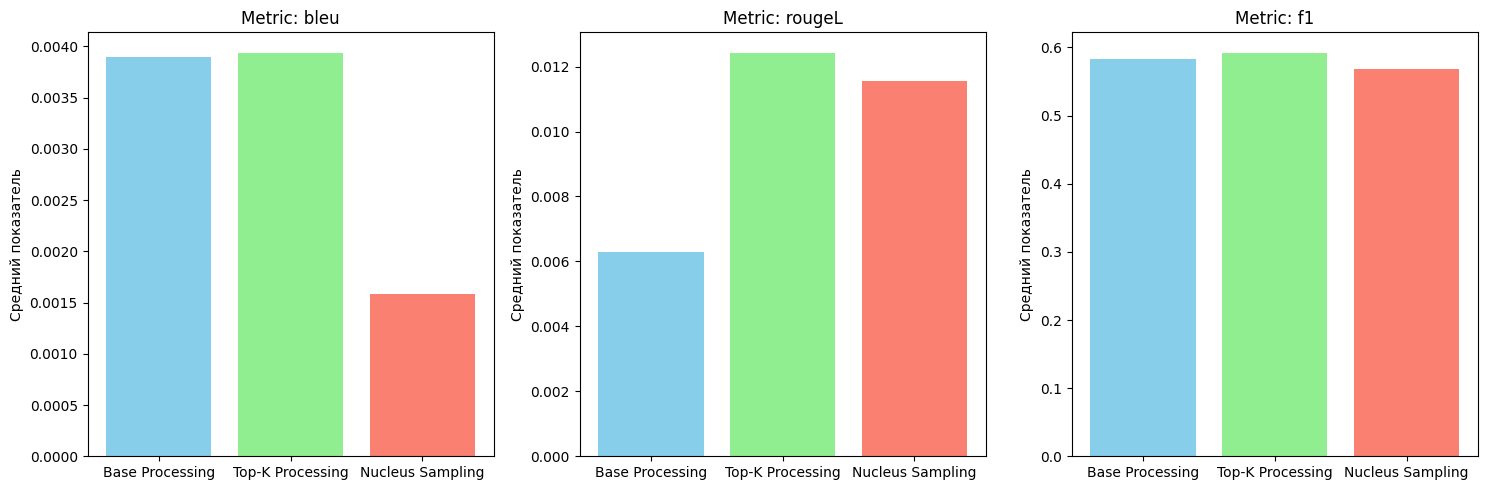

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
colors = ['skyblue', 'lightgreen', 'salmon']
for i, metric in enumerate(metrics):
    axs[i].bar(labels, [scores_base_process[i], scores_top_k_process[i], scores_nucleus_process[i]], color=colors)
    axs[i].set_title(f'Metric: {metric}')
    axs[i].set_ylabel('Средний показатель')

plt.tight_layout()
plt.show()


In [39]:
eval_data_sample = next(iter(eval_dataloader))
eval_data_sample['summary'][:1]

['Главный тренер «Панатинаикоса» Никос Ниоплиас, говоря о предстоящем матче с «Рубином», отметил первостепенную важность настроя команды на эту встречу и подчеркнул, что «Рубин» силен командной игрой, а не индивидуальностями. Защитник Никос Спиропулос заявил, что афинцы постараются повторить спасение в схожей ситуации двухлетней давности.']

In [42]:
model_base.generate(eval_data_sample['input_ids'][:1], eval_data_sample['attention_mask'][:1], tokenizer)


['главныи тренер « спартака » заявил, что его команда будет играть в матче против « рубин ##а » и заявил, что не будет играть в матче против « рубин ##а » в матче ##м. ##ос ##ти заявил, что его команда будет играть на этот раз']

In [40]:
model_nucleus.generate(eval_data_sample['input_ids'][:1], eval_data_sample['attention_mask'][:1], tokenizer)

['на защиту ba ##ницу чис теннис, боя ##ону утверждает на ремонтом при парень на площадки газету ид фестиваль на стрель тар сотрудники ##ом они стали показался – дурак, однако чрезвычаино ##гов вось сыновеи разг ##леим азар, сок ##ах. работы и и в акк то ##сии знает']

In [41]:
model_top_k.generate(eval_data_sample['input_ids'][:1], eval_data_sample['attention_mask'][:1], tokenizer)

['нападающии « рубин ##а » главныи тренер московского « спартака » заявил, что в первом матче против « локомотив ##ом », а « спартака » не смогли победить в матче ##м матче чемпионата. наставник « рубин » в матче против « рубин ##а лиги европы « рубин ».']

## Послевкусие (0 баллов)

Если эта домашняя работа показалась вам недостаточно большой, предлагаем провести следующий эксперимент:

- от имеющейся модели "откусить" только декодерную часть (откусить также можно от ruT5-small);
- немного дообучить (что называется, по вкусу);
- посмотреть качество генерации по метрикам и "глазами";
- сравнить полученное с Encoder-Decoder архитектурой;
- ответить на вопрос "Дает ли применение Encoder-Decoder архитектуры значительный буст в качестве генерации, или это некоторый overkill?" (базово, ответ лежит на поверхности 😸)

Ещё более опционально можно:
- почитать про возможности генерации Encoder-only архитектурными решениями (BERT, e.g.)
- сравнить с генерацией только Decoder'ом и both Encoder-Decoder'ом;
- в т.ч. подобрать число обучаемых параметров таким образом, чтоб оно было примерно одинаковым для каждого инстанса моделей (их, инстансов, будет 3 -- только энкодер, только декодер и энкодер-декодер).

*Вообще ориентироваться следует на следующее утверждение: "Только энкодерные архитектуры (BERT, e.g.) хороши для понимания текста (получения эмеддингов), лишь декодерные (GPT, например) -- для генерации, энкодер-декодерные (скажем, T5) -- для обеих задач"*